# import the required libraries

In [1]:
import pandas as pd
import numpy as np
import sympy as sp

In [2]:
import sys
sys.path.append('../')
from src.osrm_client import OSRMClient
from src.utils import FindMiddlePointsSymbol

# Solving linear functions 

Defines a function to solve the linear system used to determine the lines joining the middle point of each time block that will be used to represent the travel time between a pair of locations

In [3]:
# the number of middle points (hours) to be computed
T = 24

# mus are the average travel times from the origin to the middle points during the hours being computed
mus=FindMiddlePointsSymbol(T)

# us are the middle points heights (travel time starting from the origin)
u=sp.symbols('u_0:24')

In [4]:
## an example of the middle points
for t in range(24):
    print(f"u_{t} = {mus[t].subs([(u[i],10*i) for i in range(24)])}")


u_0 = -42.1286011665935
u_1 = -25.6340082939300
u_2 = 39.1570330435841
u_3 = 29.4587117318881
u_4 = 40.5004711354100
u_5 = 49.9315574523946
u_6 = 59.9956564840330
u_7 = 69.9983577301374
u_8 = 80.0003140446165
u_9 = 89.9999640047183
u_10 = 100.000008073271
u_11 = 110.000000105327
u_12 = 119.999999970831
u_13 = 130.000000769536
u_14 = 139.999993782199
u_15 = 150.000036345419
u_16 = 159.999788147082
u_17 = 170.001234774081
u_18 = 179.992803208981
u_19 = 190.041945971970
u_20 = 199.755520959255
u_21 = 211.424928272513
u_22 = 211.694909405666
u_23 = 278.405615293488


# Computing coefficient matrix to generalize computations

In [5]:
Matriz=np.zeros(shape=(24,24))


for i in range(24):
    for j in range(24):
        a = sp.Poly(mus[i], u[j])
        try:
            Matriz[i,j]=a.all_coeffs()[0]
        except:
            Matriz[i,j]=0

# deploying the prediction engine tha after will feed the piecewise linear function between each pair of persons

In [6]:
# load pickled model from file in data/train/models
model = pd.read_pickle('/Users/fabiancastano/Documents/HHCRSP/data/train/models/knn_model.pkl')
model

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model', KNeighborsRegressor(p=1, weights='distance'))])

# an usage example of the model

In [7]:
origin = (4.565939989750968,-74.0806071365743)
destination = 4.653234735184246,-74.1509113415633
# inverted origin and destination
origin = (origin[1], origin[0])
destination = (destination[1], destination[0])
osrm = OSRMClient("127.0.0.1:5001")
distance=osrm.get_distance(origin, destination)
distance

16.9634

In [8]:

# person 1 -74.1315010003499,4.566350000382421
# person 2 -74.18814699967187,4.6310979997131225
lat1, lon1 = 4.737315, -74.029834
lat2, lon2 =  4.612753, -74.077734



# create OSRM client and request distance between two points
osrm = OSRMClient("127.0.0.1:5001")
distance=osrm.get_distance([lon1,lat1 ], [lon2, lat2])
print(f"Distance: {distance} km")
X = np.array([[lon1, lat1, lon2, lat2,  distance, t] for t in range(24)])

predictions = model.predict(X)
predictions


Distance: 18.3225 km


/Users/fabiancastano/Documents/HHCRSP/venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


array([ 718.02020757,  830.27785459, 1175.50318957, 1143.28326745,
       1305.06225042, 1446.92597451, 1623.0300678 , 1876.14652728,
       1833.54620964, 1761.07393871, 1445.0414982 , 2590.4236217 ,
       1626.06243731, 2277.32447781, 1599.93643581, 2036.64506202,
       1482.11272027, 1434.04627491, 2440.58178629, 1957.64280014,
       2316.74733703, 1392.32050746, 1704.38852518, 1210.98628015])

In [9]:
middle_hours=[(0.5+i) for i in range(24)]

heights = Matriz.dot(predictions)

# range of small values with numpy

f = np.vectorize(lambda x: np.interp(x, middle_hours, heights))


/Users/fabiancastano/Documents/HHCRSP/venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


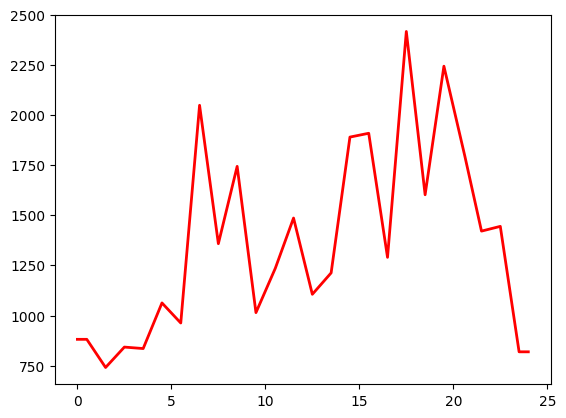

In [10]:

def get_travel_time_function(model, origin, destination):

    distance=osrm.get_distance(origin, destination)

    X = np.array([[origin[0], origin[1], destination[0], destination[1],  distance, t] for t in range(24)])
    predictions = model.predict(X)
    # create OSRM client and request distance between two points
    middle_hours=[(0.5+i) for i in range(24)]
    heights = Matriz.dot(predictions)

    
    return np.vectorize(lambda x: np.interp(x, middle_hours, heights))

f = get_travel_time_function(model, [lon2, lat2], [lon1, lat1] )

import matplotlib.pyplot as plt
x = np.arange(0, 24, 0.01)
plt.plot(x, f(x), label='Travel time', color='red', linewidth=2)
plt.show()

# read an instance

In [64]:
df_positions = pd.read_csv('/Users/fabiancastano/Documents/HHCRSP/new_Instances/HHC_25_4.csv')
df_positions.columns=['id','index','lon','lat','service_time','service_number','opt1','opt2','opt3']
df_positions.drop(columns=['index'],inplace=True)

df_positions['position'] = list(zip(df_positions['lon'],df_positions['lat']))

positions =  df_positions.set_index('id').to_dict()['position']

tw = {}

for i in range(26):
    s= np.random.randint(6,18)
    e = s + np.random.randint(1,3)/2
    if i == 0:
        tw[i] = (0,24)
        continue
    tw[i] = (s,e)



# builds a travel time matrix where each position corresponds to the piecewise linear function

In [ ]:
travel_time_matrix = {}

for i in range(len(positions)):
    for j in range(len(positions)):
        if i!=j:
            origin = positions[i]
            destination = positions[j]
            travel_time_matrix[i,j] = get_travel_time_function(model, origin, destination)


             


In [101]:
def evaluate(ruta,travel_time_matrix,start_time=6,log_route_info=False):
    current_time = start_time
    travel_time = 0
    late_time = 0
    visited = [ruta[0]]
    for i in range(len(ruta)-1):
        tt = np.round(travel_time_matrix[ruta[i],ruta[i+1]](current_time)/3600,2)
        
        if current_time+tt<18:
            visited.append(ruta[i+1])
            travel_time+=tt
            if current_time+tt>tw[ruta[i+1]][1]:
                current_time+=tt
                late_time+=current_time-tw[ruta[i+1]][1]
            if current_time<tw[ruta[i+1]][0]:
                current_time = tw[ruta[i+1]][0]            
        else:
            break

    return travel_time, late_time, len(ruta)-len(visited)

ruta = [0] + np.random.permutation(range(1,12)).tolist() + [0]
evaluate(ruta,travel_time_matrix,start_time=6)

(3.02, 29.030000000000005, 5)

In [106]:
def one_at_a_time_swap(ruta,
                       travel_time_matrix,
                       tw,
                        start_time=6):

    best_ruta = ruta
    best = np.inf
    for i in range(1,len(ruta)-2):
        for j in range(i+1,len(ruta)-1):
            new_ruta = ruta.copy()
            new_ruta[i], new_ruta[j] = new_ruta[j], new_ruta[i]
            fobj_tt, fobj_late, fobj_nv = evaluate(new_ruta,travel_time_matrix,start_time)
            total_cost= fobj_tt + 10*fobj_late + 100*fobj_nv
            if total_cost<best:
                best = total_cost
                best_ruta = new_ruta

    return best,best_ruta

ruta = [0] + np.random.permutation(range(1,12)).tolist() + [0]
one_at_a_time_swap(ruta,travel_time_matrix,tw,start_time=6)

(559.44, [0, 6, 5, 11, 10, 9, 7, 8, 4, 2, 3, 1, 0])

In [107]:
def two_opt(ruta,
            travel_time_matrix,
            tw,
            start_time=6):

    best_ruta = ruta
    best = np.inf
    for i in range(1,len(ruta)-2):
        for j in range(i+1,len(ruta)-1):
            
            new_ruta = ruta[:i] + ruta[i:j][::-1] + ruta[j+1:]
            fobj_tt, fobj_late, fobj_nv = evaluate(new_ruta,travel_time_matrix,start_time)
            total_cost= fobj_tt + 10*fobj_late + 100*fobj_nv
            if total_cost<best:
                best = total_cost
                best_ruta = new_ruta
    return best_ruta, best

ruta = [0] + np.random.permutation(range(1,12)).tolist() + [0]
two_opt(ruta,travel_time_matrix,tw,start_time=6)

([0, 10, 4, 1, 3, 8, 11, 7, 6, 5, 2, 0], 235.43999999999997)

In [120]:


class TabuSearch:

    def __init__(self, travel_time_matrix, tw, start_time=6):
        self.travel_time_matrix = travel_time_matrix
        self.tw = tw
        self.start_time = start_time

    def initial_solution(self):
        return [0] + np.random.permutation(range(1,12)).tolist() + [0]


    def one_at_a_time_swap(self, ruta):
        best_ruta = ruta
        best = np.inf
        for i in range(1,len(ruta)-2):
            for j in range(i+1,len(ruta)-1):
                new_ruta = ruta.copy()
                new_ruta[i], new_ruta[j] = new_ruta[j], new_ruta[i]
                fobj_tt, fobj_late, fobj_nv = evaluate(new_ruta,self.travel_time_matrix,self.start_time)
                total_cost= fobj_tt + 10*fobj_late + 100*fobj_nv
                if total_cost<best:
                    best = total_cost
                    best_ruta = new_ruta

        return best,best_ruta
    
    def two_opt(self, ruta):
        best_ruta = ruta
        best = np.inf
        for i in range(1,len(ruta)-2):
            for j in range(i+1,len(ruta)-1):
                new_ruta = ruta[:i] + ruta[i:j][::-1] + ruta[j+1:]
                fobj_tt, fobj_late, fobj_nv = evaluate(new_ruta,self.travel_time_matrix,self.start_time)
                total_cost= fobj_tt + 10*fobj_late + 100*fobj_nv
                if total_cost<best:
                    best = total_cost
                    best_ruta = new_ruta
        return best_ruta, best
    
    def run(self, ruta, max_iter=1000):
        best= np.inf
        for i in range(max_iter):
            objf,route = self.one_at_a_time_swap(ruta)
            if objf<best:
                best = objf
                best_ruta = route
            objf,route = self.two_opt(ruta)
            if objf<best:
                best = objf
                best_ruta = route
        return best_ruta, best
    
ts = TabuSearch(travel_time_matrix, tw, start_time=6)







best= np.inf
for i in range(1000):
    ruta = [0] + np.random.permutation(range(1,10)).tolist() + [0]
    start_time = 6
    fobj_tt, fobj_late, fobj_nv = evaluate(ruta,travel_time_matrix,start_time=start_time)
    best = fobj_tt + 10*fobj_late + 100*fobj_nv

    objf,route = one_at_a_time_swap(ruta,travel_time_matrix,tw,start_time=start_time)
    if objf<best:
        best = objf
        best_ruta = route
        print(f"new best with swap: {best}")
    objf,route == two_opt(ruta,travel_time_matrix,tw,start_time=start_time)
    if objf<best:
        best = objf
        best_ruta = route
        print(f"new best with 2 OPT: {best}")








In [114]:
best_c

[0, 2, 6, 7, 1, 4, 3, 5, 0]

In [1]:
import random
import numpy as np

class VRPTW:
    def __init__(self, num_vehicles, vehicle_capacity, customers, distance_matrix):
        self.num_vehicles = num_vehicles
        self.vehicle_capacity = vehicle_capacity
        self.customers = customers
        self.distance_matrix = distance_matrix
        self.best_solution = None
        self.best_cost = float('inf')

    def initialize_solution(self):
        solution = [[] for _ in range(self.num_vehicles)]
        customers = list(self.customers.keys())[1:]  # exclude the depot (index 0)
        random.shuffle(customers)
        
        for customer in customers:
            vehicle = random.choice(solution)
            vehicle.append(customer)
        
        return solution

    def evaluate_solution(self, solution):
        total_cost = 0
        for route in solution:
            route_cost = 0
            load = 0
            time = 0
            prev_customer = 0  # start from depot
            for customer in route:
                load += self.customers[customer]['demand']
                if load > self.vehicle_capacity:
                    return float('inf')
                
                time += self.distance_matrix[prev_customer][customer]
                if time > self.customers[customer]['time_window'][1]:
                    return float('inf')
                
                time = max(time, self.customers[customer]['time_window'][0])
                route_cost += self.distance_matrix[prev_customer][customer]
                prev_customer = customer
            
            route_cost += self.distance_matrix[prev_customer][0]  # return to depot
            total_cost += route_cost
        
        return total_cost

    def get_neighbors(self, solution):
        neighbors = []
        for i in range(len(solution)):
            for j in range(len(solution)):
                if i != j:
                    for k in range(len(solution[i])):
                        for l in range(len(solution[j])):
                            neighbor = [list(route) for route in solution]
                            neighbor[i][k], neighbor[j][l] = neighbor[j][l], neighbor[i][k]
                            neighbors.append(neighbor)
        return neighbors

    def tabu_search(self, iterations, tabu_tenure):
        current_solution = self.initialize_solution()
        current_cost = self.evaluate_solution(current_solution)
        
        tabu_list = []
        self.best_solution = current_solution
        self.best_cost = current_cost
        
        for _ in range(iterations):
            neighbors = self.get_neighbors(current_solution)
            neighbors = [(neighbor, self.evaluate_solution(neighbor)) for neighbor in neighbors]
            neighbors = sorted(neighbors, key=lambda x: x[1])
            
            for neighbor, cost in neighbors:
                if neighbor not in tabu_list or cost < self.best_cost:
                    current_solution = neighbor
                    current_cost = cost
                    tabu_list.append(neighbor)
                    if len(tabu_list) > tabu_tenure:
                        tabu_list.pop(0)
                    
                    if current_cost < self.best_cost:
                        self.best_solution = current_solution
                        self.best_cost = current_cost
                    break
        
        return self.best_solution, self.best_cost


# Example usage:

# Define the problem parameters
num_vehicles = 3
vehicle_capacity = 100
customers = {
    0: {'demand': 0, 'time_window': (0, 100)},  # depot
    1: {'demand': 10, 'time_window': (10, 20)},
    2: {'demand': 20, 'time_window': (15, 25)},
    3: {'demand': 30, 'time_window': (20, 30)},
    4: {'demand': 40, 'time_window': (25, 35)},
}
distance_matrix = np.array([
    [0, 10, 20, 30, 40],
    [10, 0, 15, 25, 35],
    [20, 15, 0, 10, 20],
    [30, 25, 10, 0, 10],
    [40, 35, 20, 10, 0],
])

# Create VRPTW instance
vrptw = VRPTW(num_vehicles, vehicle_capacity, customers, distance_matrix)

# Perform Tabu Search
best_solution, best_cost = vrptw.tabu_search(iterations=100, tabu_tenure=10)

print("Best Solution:", best_solution)
print("Best Cost:", best_cost)


Best Solution: [[4, 3, 1], [], [2]]
Best Cost: inf
